In [1]:
import os
import csv
import cv2
import glob
import numpy as np
from matplotlib import pyplot as plt
# np.set_printoptions(threshold=sys.maxsize)

In [2]:
def dnorm(x, mu, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power((x - mu) / sd, 2) / 2)

In [3]:
def myGaussianKernel(size, sigma=1, verbose=False):
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        kernel_1D[i] = dnorm(kernel_1D[i], 0, sigma)
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)

    kernel_2D *= 1.0 / kernel_2D.max()

    if verbose:
        plt.imshow(kernel_2D, interpolation='none', cmap='gray')
        plt.title("Kernel Image")
        plt.show()

    return kernel_2D

In [4]:
def myImageFilter(image, kernel, average=False, verbose=False):
    print("Image Shape : {}".format(image.shape))
    print("Kernel Shape : {}".format(kernel.shape))

    if verbose:
        plt.imshow(image, cmap='gray')
        plt.title("Image")
        plt.show()

    image_row, image_col = image.shape
    kernel_row, kernel_col = kernel.shape

    output = np.zeros(image.shape)

    pad_height = int((kernel_row - 1) / 2)
    pad_width = int((kernel_col - 1) / 2)

    padded_image = np.zeros((image_row + (2 * pad_height), image_col + (2 * pad_width)))

    padded_image[pad_height:padded_image.shape[0] - pad_height, pad_width:padded_image.shape[1] - pad_width] = image

    if verbose:
        plt.imshow(padded_image, cmap='gray')
        plt.title("Padded Image")
        plt.show()

    for row in range(image_row):
        for col in range(image_col):
            output[row, col] = np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col])
            if average:
                output[row, col] /= kernel.shape[0] * kernel.shape[1]

    print("Output Image size : {}".format(output.shape))

    if verbose:
        plt.imshow(output, cmap='gray')
        plt.title("Output Image using {}X{} Kernel".format(kernel_row, kernel_col))
        plt.show()

    return output

In [5]:
def myImageFilter(image, kernel, average=False, verbose=False):
    print("Image Shape : {}".format(image.shape))
    print("Kernel Shape : {}".format(kernel.shape))
 
    if verbose:
        plt.imshow(image, cmap='gray')
        plt.title("Image")
        plt.show()
 
    image_row, image_col = image.shape
    kernel_row, kernel_col = kernel.shape
 
    output = np.zeros(image.shape)
 
    pad_height = int((kernel_row - 1) / 2)
    pad_width = int((kernel_col - 1) / 2)
 
    padded_image = np.zeros((image_row + (2 * pad_height), image_col + (2 * pad_width)))
 
    padded_image[pad_height:padded_image.shape[0] - pad_height, pad_width:padded_image.shape[1] - pad_width] = image
 
    if verbose:
        plt.imshow(padded_image, cmap='gray')
        plt.title("Padded Image")
        plt.show()
 
    for row in range(image_row):
        for col in range(image_col):
            output[row, col] = np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col])
            if average:
                output[row, col] /= kernel.shape[0] * kernel.shape[1]
 
    print("Output Image size : {}".format(output.shape))
 
    if verbose:
        plt.imshow(output, cmap='gray')
        plt.title("Output Image using {}X{} Kernel".format(kernel_row, kernel_col))
        plt.show()
 
    return output

In [6]:
def findImageCorners(gray_img, kernel, verbose=False):
    k = 0.04
    window_size = 5
    threshold = 10000.00

    # dy, dx = np.gradient(gray_img) # skip builtin method
    Gxy = myImageFilter(gray_img, kernel, average=True)
    dy = np.diff(Gxy, axis=0, append=0)
    if verbose:
        plt.title("y derivative image")
        plt.imshow(dy, cmap='gray')
        plt.show()
    dx = np.diff(Gxy, axis=1, append=0)
    if verbose:
        plt.title("x derivative image")
        plt.imshow(dx, cmap='gray')
        plt.show()

    offset = int(window_size / 2)
    y_range = gray_img.shape[0] - offset
    x_range = gray_img.shape[1] - offset

    print("Gxy Shape : {}".format(Gxy.shape))
    print("dy Shape : {}".format(dy.shape))
    print("dx Shape : {}".format(dx.shape))

    Ixx = dx ** 2
    Ixy = dy * dx
    Iyy = dy ** 2

    corner_list = []
    output_img = cv2.cvtColor(gray_img.copy(), cv2.COLOR_GRAY2RGB)
    for y in range(offset, y_range):
        for x in range(offset, x_range):
            # Values of sliding window
            start_y = y - offset
            end_y = y + offset + 1
            start_x = x - offset
            end_x = x + offset + 1

            # The variable names are representative to
            # the variable of the Harris corner equation
            windowIxx = Ixx[start_y: end_y, start_x: end_x]
            windowIxy = Ixy[start_y: end_y, start_x: end_x]
            windowIyy = Iyy[start_y: end_y, start_x: end_x]

            # Sum of squares of intensities of partial derevatives
            Sxx = windowIxx.sum()
            Sxy = windowIxy.sum()
            Syy = windowIyy.sum()

            # Calculate determinant and trace of the matrix
            det = (Sxx * Syy) - (Sxy ** 2)
            trace = Sxx + Syy

            # Calculate r for Harris Corner equation
            r = det - k * (trace ** 2)

            if r > threshold:
                corner_list.append([x, y, r])
                output_img[y, x] = (0, 0, 255)

    if verbose:
        plt.title("x derivative image")
        plt.imshow(output_img, cmap='gray')
        plt.show()

    return corner_list, output_img



In [7]:
def saveCornerResult(filename, corner_list, corner_img):
    with open(os.path.join("output", "charts", f"{filename}.csv"), 'w') as corner_file:
        writer = csv.DictWriter(corner_file, fieldnames=["x", "y", "r"])
        writer.writeheader()
        for i in range(len(corner_list)):
            writer.writerow({
                "x": str(corner_list[i][0]),
                "y": str(corner_list[i][1]),
                "r": str(corner_list[i][2])
            })

    if corner_img is not None:
        cv2.imwrite(os.path.join("output", "images", filename), corner_img)

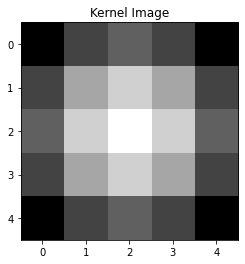

array([[0.36787944, 0.53526143, 0.60653066, 0.53526143, 0.36787944],
       [0.53526143, 0.77880078, 0.8824969 , 0.77880078, 0.53526143],
       [0.60653066, 0.8824969 , 1.        , 0.8824969 , 0.60653066],
       [0.53526143, 0.77880078, 0.8824969 , 0.77880078, 0.53526143],
       [0.36787944, 0.53526143, 0.60653066, 0.53526143, 0.36787944]])

In [8]:
kernel = myGaussianKernel(size=5, sigma=2, verbose=True)
kernel

Image Shape : (256, 256)
Kernel Shape : (5, 5)
Output Image size : (256, 256)


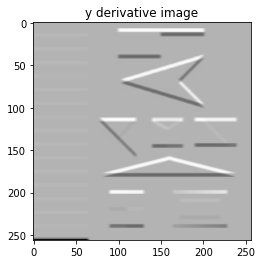

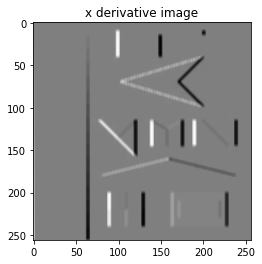

Gxy Shape : (256, 256)
dy Shape : (256, 256)
dx Shape : (256, 256)


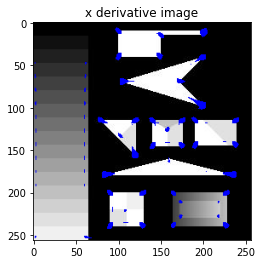

Input img2.gif: OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-h4wtvo23\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Image Shape : (384, 384)
Kernel Shape : (5, 5)
Output Image size : (384, 384)


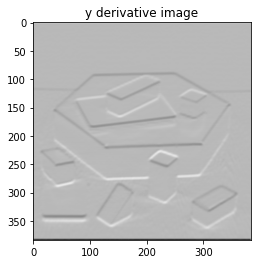

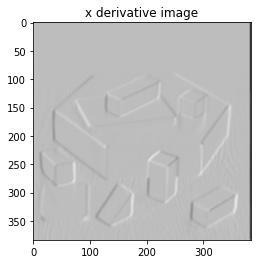

Gxy Shape : (384, 384)
dy Shape : (384, 384)
dx Shape : (384, 384)


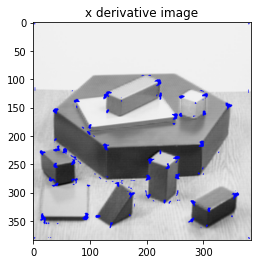

Image Shape : (512, 512)
Kernel Shape : (5, 5)
Output Image size : (512, 512)


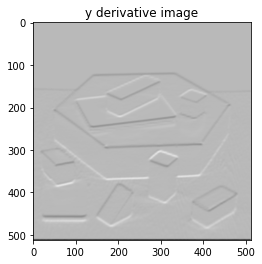

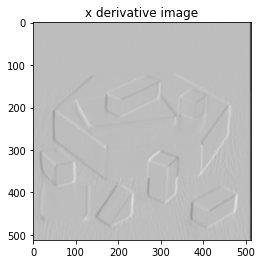

Gxy Shape : (512, 512)
dy Shape : (512, 512)
dx Shape : (512, 512)


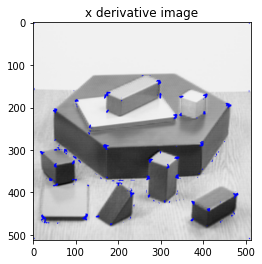

Input img3.gif: OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-h4wtvo23\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Image Shape : (384, 384)
Kernel Shape : (5, 5)
Output Image size : (384, 384)


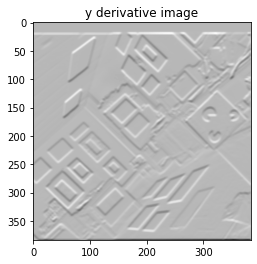

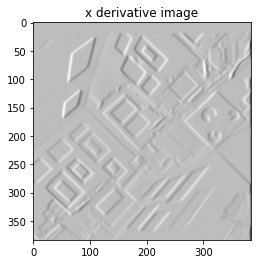

Gxy Shape : (384, 384)
dy Shape : (384, 384)
dx Shape : (384, 384)


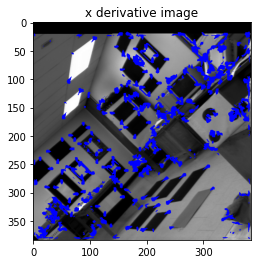

Image Shape : (576, 576)
Kernel Shape : (5, 5)
Output Image size : (576, 576)


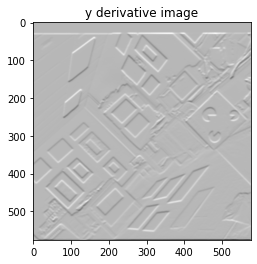

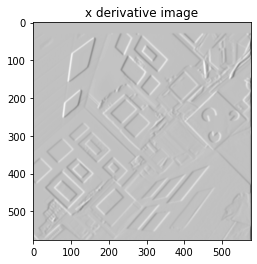

Gxy Shape : (576, 576)
dy Shape : (576, 576)
dx Shape : (576, 576)


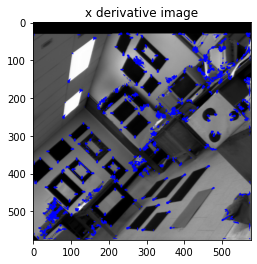

Image Shape : (768, 768)
Kernel Shape : (5, 5)
Output Image size : (768, 768)


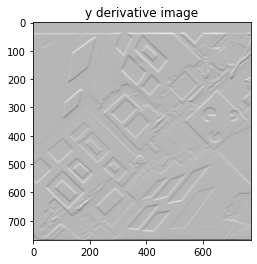

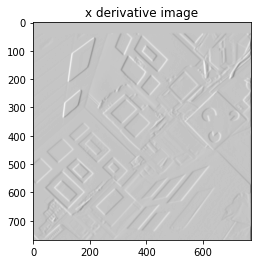

Gxy Shape : (768, 768)
dy Shape : (768, 768)
dx Shape : (768, 768)


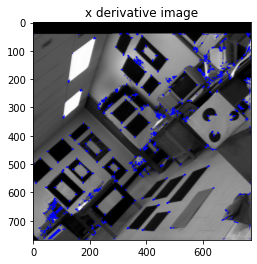

In [9]:
files = glob.glob(os.path.join("images", "img*"))
for file in files:
    filename = file.split(os.path.sep)[-1]
    try:
        input_img = cv2.imread(file)
        gray_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    except Exception as error:
        print(f"Input {filename}: {error}")
        continue
    corner_list, output_img = findImageCorners(gray_img, kernel, verbose=True)
    # saveCornerResult(filename, corner_list, output_img)